In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from dataset import Dataset
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew
import opensmile
from tqdm import tqdm
import seaborn as sns

tqdm.pandas()

In [12]:
data = Dataset()
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)
data.df['opensmile'] = data.df['Path'].progress_apply(smile.process_file)

100%|██████████| 1440/1440 [03:05<00:00,  7.77it/s]


In [3]:
y = data.df['Emotion'].values
print(y.min(), y.max())

0 7


In [14]:
values = data.df['opensmile'].values
X = np.array([x.values for x in values]).squeeze()
y = data.df['Emotion'].values

svm = LinearSVC(dual='auto')
scale = StandardScaler()
X = scale.fit_transform(X)
#search = GridSearchCV(svm, {
#    'C': [0.001],
#}, cv=5, n_jobs=-1, verbose=10)
#search.fit(X, y)

In [5]:
print(search.best_params_)
print(search.best_score_)

{'C': 0.001}
0.6048611111111111


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
svm = LinearSVC(dual='auto', C=0.001)
svm.fit(X_train,y_train)

LinearSVC(C=0.001, dual='auto')

In [21]:
y_pred = svm.predict(X_test)

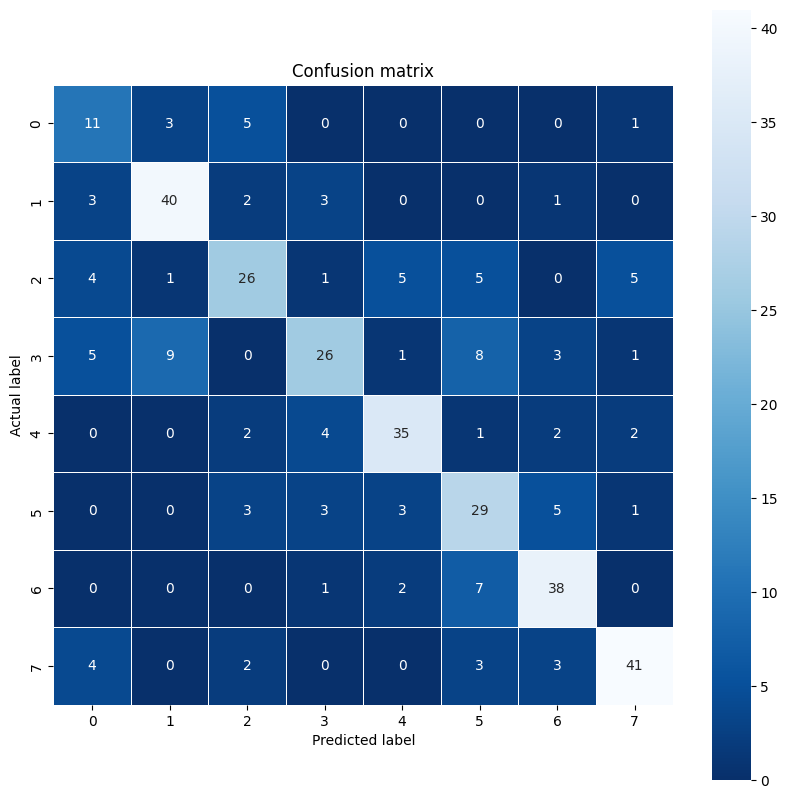

In [22]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

In [23]:

#print classwise accuracy
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47        20
           1       0.75      0.82      0.78        49
           2       0.65      0.55      0.60        47
           3       0.68      0.49      0.57        53
           4       0.76      0.76      0.76        46
           5       0.55      0.66      0.60        44
           6       0.73      0.79      0.76        48
           7       0.80      0.77      0.79        53

    accuracy                           0.68       360
   macro avg       0.67      0.67      0.67       360
weighted avg       0.69      0.68      0.68       360



In [8]:
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scale, f)

In [30]:
class AudioTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,n_mfcc):
        self.n_mfcc = n_mfcc
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X_new = []
        for x in X:
            mfcc = librosa.feature.mfcc(y=x,sr=16000,n_mfcc=self.n_mfcc,hop_length=160,n_fft=400)
            mean = mfcc.mean(axis=-1)
            std = mfcc.std(axis=-1)
            rms = librosa.feature.rms(y=x,frame_length=400,hop_length=160)
            rms_mean = rms.mean(axis=-1)
            rms_std = rms.std(axis=-1)
            pitch,mag = librosa.core.piptrack(y=x,sr=16000,n_fft=400,hop_length=160)
            pitch_mean = pitch.mean(axis=-1)
            pitch_std = pitch.std(axis=-1)
            mag_mean = mag.mean(axis=-1)
            mag_std = mag.std(axis=-1)
            X_new.append(np.concatenate([mean,std,rms_mean,rms_std,pitch_mean,pitch_std,
                                         mag_mean,mag_std]))
        return np.array(X_new)

pipeline = Pipeline([
    ('transformer',AudioTransformer(n_mfcc=32)),
    ('clf',LogisticRegression())
])

search = GridSearchCV(pipeline,{
    #'pca__n_components':[64,128],
    'clf__penalty':['none','l2'],
    },cv=5,verbose=10)

#data = Dataset()

In [31]:
X = data()['Audio'].values
y = data()['Emotion'].values

search.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START clf__penalty=none...........................................


/home/sid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/sid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 1/2] END ............clf__penalty=none;, score=0.281 total time=  22.2s
[CV 2/5; 1/2] START clf__penalty=none...........................................


/home/sid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/sid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 1/2] END ............clf__penalty=none;, score=0.250 total time=  23.4s
[CV 3/5; 1/2] START clf__penalty=none...........................................


KeyboardInterrupt: 

In [29]:
print(search.best_params_)
print(search.best_score_)

{'clf__penalty': 'l2'}
0.26041666666666663
